In [1]:
# Python ≥3.5 is required
import sys

assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn

assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Downloading the data that contains the housing information

In [2]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"


def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

# Load the data into a Pandas DataFrame

In [4]:
import pandas as pd


def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# Getting info about the data

In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


# Understanding what's in the ocean_proximity field

In [7]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

# Get a summary for numerical attributes to understand better the data

In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


# Get a histogram for all numerical attributes

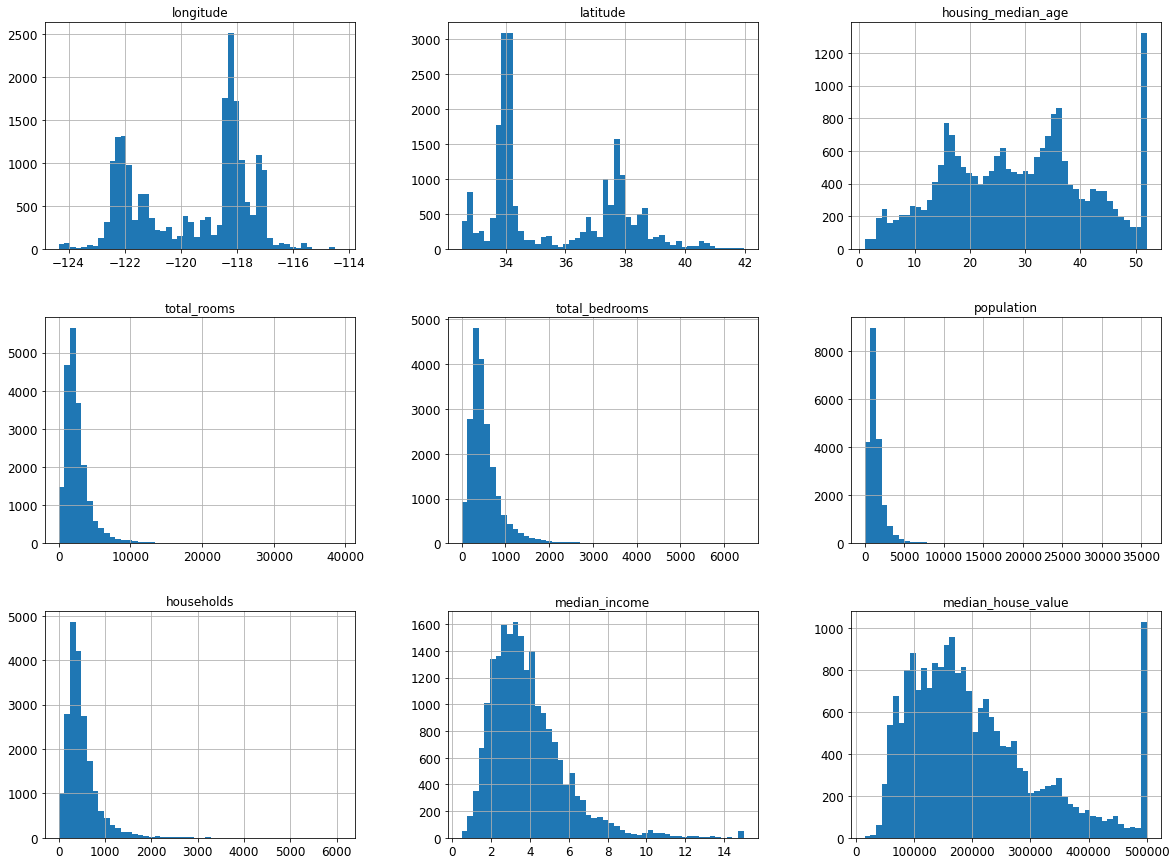

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(20, 15))
plt.show()

# Creating the test set from the by keeping 20% of the training data

In [10]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [11]:
import numpy as np


def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

To use it we can do this

In [12]:
train_set, test_set = split_train_test(housing, 0.2)
len(train_set)

16512

In [13]:
len(test_set)

4128

This solution is not great because every run it will split it differently every time. Splitting it once or using a predefined seed the random generator could be a solution, but we still have the problem of updating the data(adding to it). When updating we will still get a different test set.

A solution is to use the identifier of every instance to generate a hash and decide if it goes into the test set based on that. If the hash is smaller or equals to 20% of the max hash value it goes in the test set. This means it will be consistent even if the data is updated.

In [14]:
from zlib import crc32


def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2 ** 32


def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

Unfortunately, the housing data does not have an identifier column. The simplest solution is to add the row index as the ID

In [15]:
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [16]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
5,5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY
16,16,-122.27,37.85,52.0,1966.0,347.0,793.0,331.0,2.7750,152500.0,NEAR BAY
23,23,-122.27,37.84,52.0,1688.0,337.0,853.0,325.0,2.1806,99700.0,NEAR BAY


If we use the row ID as the identifier we still have some problems because the IDS will get fucked if data is added in the middle of the list or something gets deleted. In situations like these we should use something mode stable like the district latitude and longitute to generate and ID to use

In [17]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
59,59,-122.29,37.82,2.0,158.0,43.0,94.0,57.0,2.5625,60000.0,NEAR BAY,-122252.18
60,60,-122.29,37.83,52.0,1121.0,211.0,554.0,187.0,3.3929,75700.0,NEAR BAY,-122252.17
61,61,-122.29,37.82,49.0,135.0,29.0,86.0,23.0,6.1183,75000.0,NEAR BAY,-122252.18
62,62,-122.29,37.81,50.0,760.0,190.0,377.0,122.0,0.9011,86100.0,NEAR BAY,-122252.19
67,67,-122.29,37.80,52.0,1027.0,244.0,492.0,147.0,2.6094,81300.0,NEAR BAY,-122252.20


Instead of doing any of this we can use a method from Scikit-Learn called train_test_split() which does pretty much the same thing as our method, but it also has a random_state parameter which we can use to set the random generator seed. We can also pass multiple datasets with identical nr of rows and split them on the same indices.

In [18]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


So far we used random sampling methods but with this we can introduce a lot of sampling bias. From example there are 51.3% men and 48.7% women and you need a sample of 1000 entries. You take 513 entries from men and 487 from women. This is called stratified sampling where we divide the data into strata.
We assume that the median income is important to predict the median housing prices, so we want the test set to be representative of the various categories of incomes in the whole dataset. To do this we need a categorical value for the median income like splitting it into 5 categories from 1 to 5. Looking at the histogram of the median income we can split so that we have enough data in each set so we focus on the first part since that's where we have a lot of data

<AxesSubplot:>

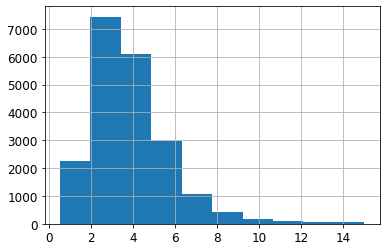

In [19]:
housing["median_income"].hist()

<AxesSubplot:>

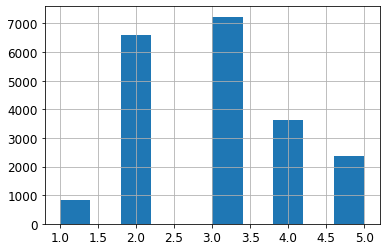

In [20]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0, 1.5, 3.0, 4.5, 6.0, np.inf], labels=[1, 2, 3, 4, 5])
housing["income_cat"].hist()

Now since we have the strata, we can do stratified sampling based on the income category and we can use Scikit-Learn's StratifiedShuffleSplit

In [21]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

We can now look at the income category proportions in the test set to the training set to see if it worked

In [22]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [23]:
strat_train_set["income_cat"].value_counts() / len(strat_train_set)

3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: income_cat, dtype: float64

In [24]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)


train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.039826,0.039971,0.040213,0.973236,0.364964
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114341,0.109496,-4.318374,-0.084674


As we can see the proportions are very similar.
Now we should remove the income_cat column so the data is back to original structure

In [25]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [26]:
strat_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN


# Visualizing the data
First we need to copy the data


In [27]:
housing = strat_train_set.copy()

We can plot the data


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

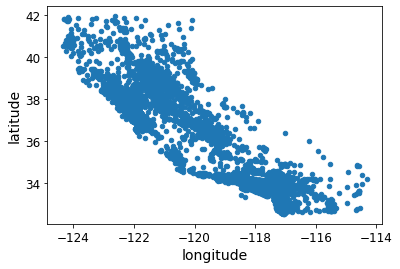

In [28]:
housing.plot(kind="scatter", x="longitude", y="latitude")

Its hard to see density like this so we can set the alpha lower


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

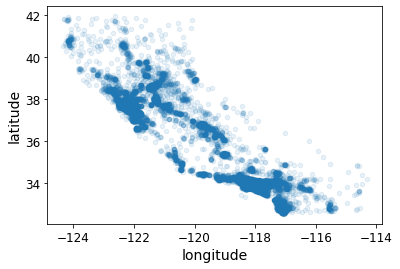

In [29]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

In addition, to help spotting patterns we can do more. We can use the population for the radius os each district circle and we can use the price to represent the color using a predefined color map called jet that will show from blue to red, red meaning a higher price.


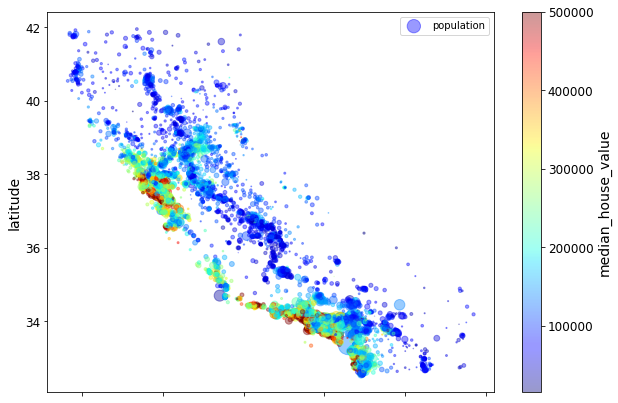

In [30]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"] / 100, label="population", figsize=(10, 7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()

# Looking for correlations
We can start looking for correlations by computing the standard correlation coefficient(Pearson's r) between every pair of attributes and we can check which attributes have a stronger correlation to the median house value.


In [31]:
corr_matrix = housing.corr()

In [32]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

Another way to check correlations is using pandas scatter_matrix, it will plot every numerical attribute against each other. For the whole dataframe it would plot 11^2=121 plot which are too many so let's just look at the combinations that we think are promising.


array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

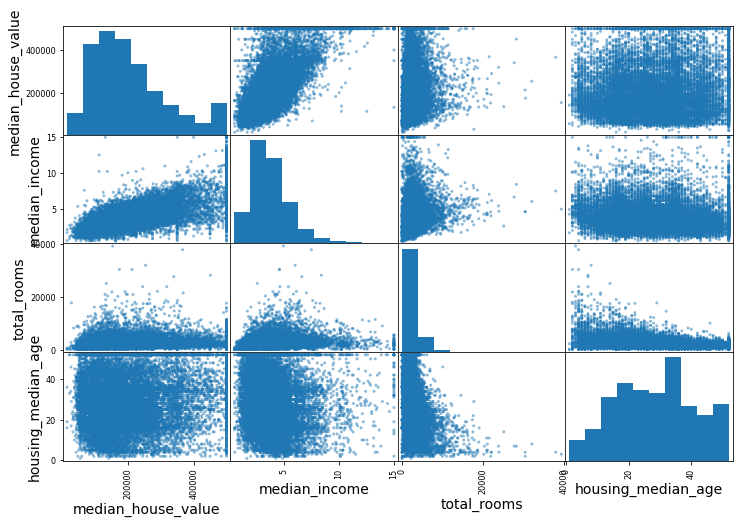

In [33]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))


We can ignore the main diagonal because it plots the attributes against themselves and focus on the rest.
The most promising attribute is the median_income as it have a pattern. Let's look closer.


<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

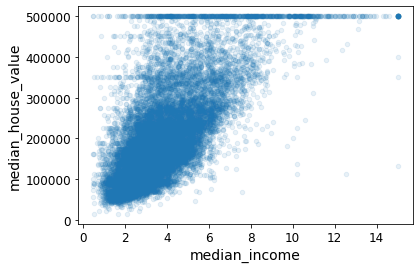

In [34]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)


We can see some interesting things. There's a good correlation as we can see that the house value goes up as the income does and the
points are not too scattered.
We can also see a price cap at 500k as a horizontal line. Nothing is above 500k. There also seem to be some lines at 450k, 350k, maybe at 280k and maybe a few more below.
We should consider cleaning up the data by removing the corresponding districts to prevent our algorithm learning these trends(like being capped at 500k or favoring a 450k price)


# Experimenting withe Attribute Combinations
So far we found some quirks in the data  and some cool correlations. We also noticed some attributes have a tail-heavy distribution that we can transform (ex. by computing their logarithm).
Now we can try different attribute combinations that could help us with our algorithm.
For example, the total nr of rooms in a district is quite useless. We could be interested in total nr of rooms / household though.
Same goes for total nr of bedrooms. We would like to compare it to the number of rooms. Population per household might also be insightful for us. Let's create these attributes:

In [35]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

Let's look again at the correlation matrix with these new fields


In [36]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)


median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

The attribute bedrooms_per_room that we added is much more correlated with the median house value than the total nr of rooms or bedrooms.
It seems that houses with a smaller nr of bedrooms in relation to all the rooms seem to be more expensive.
The rooms_per_household field is also home correlated than the total_rooms. Makes sense, larger the house, more expensive it is.
We don't need to go in a lot of detail. The idea is to get some insights and get going soon with a good prototype. After that we can go back and iterate once we know more.


# Preparing the Data for ML Algorithms


Preparing the data for the ML algorithm should be ideally done in code, so we can reproduce these transformations on any data set. Thus, we will gradually build a library of transformation functions that we can reuse. We can also use this code to transform new data before feeding it to the algorithm.

Let's revert to a clean training set. We'll also separate the predictors and the labels since we don't want to apply the same transformations on both of them.


In [37]:
housing = strat_train_set.drop("median_house_value", axis=1)  #drop also returns a copy
housing_labels = strat_train_set["median_house_value"].copy()

## Data Cleaning


ML Algorithms  cannot work with missing features so we need to fix those. We saw that total_bedrooms attribute has some missing values. There are some ways of fixing it:
1. Get rid of the corresponding districts
2. Get rid of the whole attribute
3. Set the missing values to some value (zero, the mean, the median etc)


In the book 3 options are listed:

```python
housing.dropna(subset=["total_bedrooms"])    # option 1
housing.drop("total_bedrooms", axis=1)       # option 2
median = housing["total_bedrooms"].median()  # option 3
housing["total_bedrooms"].fillna(median, inplace=True)
```

To demonstrate each of them, let's create a copy of the housing dataset, but keeping only the rows that contain at least one null. Then it will be easier to visualize exactly what each option does:


In [38]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,NaN,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,NaN,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,NaN,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,NaN,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,NaN,1145.0,480.0,6.3580,NEAR OCEAN


In [39]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])  # option 1


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [40]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)  # option 2


,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,1145.0,480.0,6.3580,NEAR OCEAN


In [41]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True)  # option 3
sample_incomplete_rows


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580,NEAR OCEAN


Scikit-Learn provides a handy class to take care of missing values: SimpleImputer. Here's how to use it:


In [42]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")


Since the median can only be computed on numerical attributes, we need to create a copy of the data without the ocean_proximity attribute


In [43]:
housing_num = housing.drop("ocean_proximity", axis=1)


We can now fit the imputer on the training data using fit()


In [44]:
imputer.fit(housing_num)


SimpleImputer(strategy='median')

The imputer has simply computed the median of each attr and stored it in its statistics_ instance variable. Only total_bedrooms attr had missing values for us, but we're not sure we won't have missing data on a new test set in other attrs so this is better.


In [45]:
imputer.statistics_


array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [46]:
housing_num.median().values


array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

Now we can use the trained imputer to transform the training set by replacing missing values with the found median


In [47]:
X = imputer.transform(housing_num)


In [48]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
housing_tr.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964


## Handling Text and Categorical Attributes


After dealing a lot with numerical attributes it's time to look at the text attributes. In our case it's the ocean_proximity.


In [49]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


It seems  it's not an arbitrary text but a limited number of possible values. Most ML algorithms work well with numbers so let's convert these categories into numbers. We can use Scikit-Learn's OrdinalEncoder for this


In [50]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]


array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [51]:
ordinal_encoder.categories_


[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

One issue is that ML algorithms will assume that 2 nearby values are more similar than 2 distant values. This is good for cases like bad,average,good,excellent bit it's not the case here: categories 0(<1H OCEAN) and 4(NEAR OCEAN) are more similar than 0(<1H OCEAN) and 1(INLAND)
To fix this issue, a common solution is to create one binary attribute per category: 1 attr equal to 1 when the category is "<1H OCEAN"(and 0 otherwise), another attribute equal to 1 when category is "INLAND" (and 0 otherwise) and so on. This is called one-hot encoding because only 1 attribute will be equal to 1 (hot) and the rest will be 0 (cold). The new attrs are sometimes called dummy attrs. This basically results in matrix with a row per category, with value 1 specifying the category and 0 for the rest.
Scikit-Learn  provides a OneHotEncoder class to convert categorical values into one-hot vectors:


In [52]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot


<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

The output is a sparce matrix instead of an array of arrays. This is useful when you do this for thousands of categories. The resulted matrix using one hot encoding can be huge with a lot of 0s just a single 1 per row. This would use tons of memory to store the 0s but a sparce matrix only stores the location of the nonzero elements. We can actually use it mostly as a 2D array but if we want we can convert it to a dense NumPy array like this:


In [53]:
housing_cat_1hot.toarray()


array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

We can still see the list of categories the same way


In [54]:
cat_encoder.categories_


[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

If a categorical attribute is very large (country, profession, species) then one hot encoding will result in a very large input. This may slow down training and degrade performance. If this happens we can replace the categorical input with useful numerical features like converting ocean_proximity  to a number representing the distance from the ocean. Similarly, a country code can be replaced with the country population or GDP.
Alternatively, you could replace each category with a learnable, low-dimensional vector called an embedding. Each category's representation would be learned during training. This is an example of representation learning.


## Custom Transformers


Sometimes we need to write our own Scikit Learn transforms for custom cleanup operations or combining attributes or transforming them. We want our customer transformers to work well with Scikit to be able to use the API functionalities(like pipelines) and it will work easily because Scikit works on duck-taping rather than inheritance. All we need to do is implement a class that has 3 methods: fit (returning self), transform and fit_transform.
fit_transform can be added automatically by extending the TransformerMixin class. Extending BaseEstimator(and avoiding *args and **kargs in constructor) class adds 2 methods(get_params() and set_params()) that we can use for auto hyperparameter tuning. Let's write a custom transformer that adds the combined attrs we played around earlier:


In [55]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6


class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):  #no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        rooms_per_household = X[:, bedrooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]


attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)



With this class we added one hyperparameter called add_bedrooms_per_room set to True by default. This hyperparameter allows us to find out easily if adding this attribute will help the ML algorithm or not.
We can do this as a rule for hyperparameters. We can add a hyperparam to gate any data preparation step that we're not 100% sure about. The more we do this and automate these preparation steps the more combinations we can try out automatically making it easier to find a great combination for the best result.

## Feature Scaling


ML Algorithms don't normally perform well  when numerical attributes have very different scales. For this case total nr of rooms ranges from 0 to 39320 while median income ranges from 0 to 15.

Note that scaling the target values is not usually required.

There are 2 common ways to get attrs to the same scale:
1. Min-max scaling(Normalization): quite simple. Values are rescaled so they end up ranging from 0 to 1. It's done by subtracting the min value and dividing by the max minus the min. Scikit Learn has a transformer for this called MinMaxScaler. It also has a feature_range hyperparameter that allows to change the range if we don't want 0-1
2. Standardization: It subtracts the mean value and then it divides it by the standerd deviation so that the resulting distribution has unit variance(meters vs calories vs distance). Unlike min-max scaling, here we do not bound values to a specific range which can be a problem for certain algorithms(neural networks often expect 0-1 range values). However standardization is not as affected by outliers. If we have a mistake in the data of a median income being set to 100(the rest are 0-15) then 100 would be the max(aka 1) which would crunch down all the other values of 0-15 to 0-0.15 in the range. Standardization would not be much affected by this 100 median income mistake. Scikit Learn offers this through the StandardScaler transformer


## Transformation Pipelines


Like in this situation we will usually have many data transformation steps that needs to be done in a certain order. For this Scikit Learn has a Pipeline class to help with sequences of transformations. Here's how to combine all the above transformers to prepare the data using a Pipeline:


In [56]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)


Pipeline constructor takes a list of name/estimator pair. All but the last entry in the list must be transformers(have fit_transform method).
Names can be what we like as long as unique and don't have __ . We need them later for hyperparameter tuning.
When we use fit() in the Pipeline it calles fit_transform() on all transformers, passed the output to the next transformer until the last one for which it calls fit().
The pipeline exposes the same methods as the final estimator. For us, it's the StandardScaler which is a tranformer, so we can use transform() and fit_transform().

So far we handled numerical columns separate from categorical columns. It's easier to have a single transformer to handle all columns that applies the correct transformations for each column. Scikit Learn offers ColumnTransformer for this purpose. Let's use this to also include the transformations for the categorical columns(ocean proximity):


In [57]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(handle_unknown='ignore'), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)

The ColumnTransformer class gets a list of tuples where each tuple contains a name, a transformer and a list of names or indices of columns.
A pipeline is still a transformer as seen by setting the pipeline as the transformer for the numerical columns.
This way we can apply the transformers we want on the columns we want.

Instead of a transformer we can use the string "drop" to drop certain columns and "passthrough" for columns that we want untouched.
By default, columns that are not listed in the ColumnTransformer will be dropped. If we need them, we can set the remainder hyperparameter to any transformer or to "passthrough" if we need these columns.

OneHotEncoder makes a sparse matrix while the num_pipeline makes a dense_matrix. When sucha  mix happens the ColumnTransformer returns a sparse matrix if the density is lower than a threshold or a dense matrix otherwise. In our case it returned a dense matrix.
This is the full transformation pipeline before we can apply the ML algorithm!


# Select and train a Model


We framed the problem, we got the data and explored it, we sampled a training and test set and we wrote transformation pipeline to cleanup and prepare the data. We can now start selecting and training an ML algorithm.


Let's start training a LinearRegression model which is quite simple


In [58]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)


LinearRegression()

Done! Let's try it out on a few instances from the training set


In [59]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))


Predictions: [ 86327.32120461 306269.39222521 151686.37104253 186320.19298729
 244575.9553263 ]
Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


It worked but the predictions are not accurate(even off by 40%). Let's measure the the model's RMSE on the whole training set using Scikit Learn's mean_squared_error() function


In [60]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse


68789.58126449553

It's better than nothing but far from a great score. Most median_housing_value range from 120k to 265k so a 68k prediction error is not good. This is an example of underfitting the training data. This can happen when we dont give enough info to make good predictions or the model is powerful enough.
As we know, we can fix it by finding a more powerful model, feeding the training algorithm with better features or to reduce the constraints of the model. Let's try a more complex model first.


We can try a DecisionTreeRegressor. It's a powerful model, capable of finding complex non-linear relationships in the data.


In [61]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)


DecisionTreeRegressor()

Now we evaluate it on the training set


In [62]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

What? No error? Is this model perfect? No, more likely the model badly overfitted the data. How can we check this?
We don't want to touch the test data until we're ready to launch a model that we are confident about so we should use part of the training data for training and the rest for part for model validation.


## Better Evaluation Using Cross-Validation


One way to evaluate the Decision Tree model is to use the train_test_split() function to train the model on a smaller training set and evaluate on the validation set.

An alternative is Scikit Learn K-fold cross-validation feature. This code splits  the training set into 10 distinct folds then trains and evaluates the DecisionTree model 10 times, using a different fold every time and training on the other 9 folds. The result is an array conaining 10 evaluation scores:


In [63]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)


In [64]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())


display_scores(tree_rmse_scores)

Scores: [73118.90891527 72063.01716315 70184.39806049 69746.34396055
 68820.66882013 75358.59406133 73356.28407885 73497.74271815
 71218.79506651 71639.64962299]
Mean: 71900.44024674335
Standard Deviation: 1890.591360935456


It seems the Decision Tree model  actually performs worse than the Linear Regression model. With cross validation we can get en estimate of the performance of our model and also measure how precise the estimate is (through the standard deviation).
For us the model has a score of approx 71900, generally +- 1890. We would not have gotten this info with just one validation set. Cross validation takes training the model several times so it's not always possible.
Let's also check the Linear Regression model using cross validation:


In [65]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)


Scores: [71801.99837884 65015.07583697 67659.2906864  68827.61774507
 67026.6711897  72547.86158248 75116.24236759 68966.54738073
 66561.96285809 70397.64938435]
Mean: 69392.09174102091
Standard Deviation: 2929.3175034032456


Yes, the Decision Tree model is overfitting so badly that it performs worse that a Linear Regression.

Let's try a Random Forest model called RandomForestRegressor. Random forests work by training many Decision Trees on random subsets of the features then averaging out their predictions. A model built on top of other models like this is called Ensemble Learning.


In [66]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
forest_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, forest_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18913.35122008425

In [67]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)


Scores: [51785.28721652 49892.35788702 46943.41424603 52188.15985511
 47664.34301707 51539.84835219 52726.10378267 49624.51149337
 48248.45767654 54721.86609928]
Mean: 50533.4349625802
Standard Deviation: 2350.4690725961204


Random Forests look much more promising. However the score on the training set is still much lower than the score on the validation set meaning that the model is still overfitting the data.
To fix this, we should simplify the model, constrain it or get more training data.


# Fine-Tune Your Model


Once we have a shortlist of promising models we need to fine-tune them.

## Grid Search
One way is to play with the hyperparameters manually to find the best combination but this would be very tedious.
Instead, we can use Scikit Learn's GridSearchCV to search the combinations for us. We just need to tell it which hyperparams to play with and what values to try out and it will use cross-validation to evaluate all the possible combinations. Here's how we do it on the RandomForestRegressor:


In [68]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

When we don't know what value a hyperparam should have a simple approach is to try out consecutive powers of 10 or less if we want a more fine-grained search.

The param_grid tells the algorithm  to evaluate all 3 * 4 = 12 combinations of n_estimators and max_features send in the first map, then try all the 2 * 3 = 6 combinations of hyperparam values in the second map but this time with bootstrap hyperparam set to False instead of True.
The grid search will them check 12 + 8 = 18 combinations and will train each model 5 times(set in cv param which is the number of cross folds).
18 * 5 = 90 which means 90 rounds of training.

In [69]:
grid_search.best_params_


{'max_features': 8, 'n_estimators': 30}

Note: if the grid search finds that the best combination for some params are the max(like here) or min that you set you might want to adjust to see if it going higher or lower will be even better.

We can also get the best estimator directly:


In [70]:
grid_search.best_estimator_


RandomForestRegressor(max_features=8, n_estimators=30)

We can also see the evaluation scores:


In [71]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)


63250.44269729393 {'max_features': 2, 'n_estimators': 3}
55678.78617533565 {'max_features': 2, 'n_estimators': 10}
52935.64900187863 {'max_features': 2, 'n_estimators': 30}
60419.02017467875 {'max_features': 4, 'n_estimators': 3}
52771.840214210584 {'max_features': 4, 'n_estimators': 10}
50563.99940995276 {'max_features': 4, 'n_estimators': 30}
58018.371324723856 {'max_features': 6, 'n_estimators': 3}
52024.95342648567 {'max_features': 6, 'n_estimators': 10}
50005.21391786538 {'max_features': 6, 'n_estimators': 30}
59652.9400143756 {'max_features': 8, 'n_estimators': 3}
52404.67316571406 {'max_features': 8, 'n_estimators': 10}
49831.56585743986 {'max_features': 8, 'n_estimators': 30}
62271.15550473995 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
53703.89318547996 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60661.93295206813 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52613.64264599193 {'bootstrap': False, 'max_features': 3, 'n_estimators': 1

By using n_estimator=30 and max_features=8 we get 49831 which is a better score than 50530 that we had before!

It's worth noting that you can treat some data preparation steps and hyperparams to allow the grid search to check if adding or not that feature will be better (like we added add_bedrooms_per_room). It can be also used tu automatically find the best way to handle outlier,  missing features, feature selection and more.


## Randomized Search

The grid search is great when exploring a smaller number of combinations but when we have a low of hyperparameters  we should use RandomizedSearchCV.
This class can be used like GridSearchCV but instead of trying aout all combinations it evaluates a given number of random combinations by selecting a random value for each hyperparam at every iteration. It helps with exploring more values and you can control the computing budget you invest by setting the nr of iterations.

## Ensable methods

Another way to find tune  is to combine models to see if they perform best. Ensambles will often perform better than individual models.


# Analyze the Best Models and Their Errors


We will often gain good info by inspecting the best models. For example using the grid search we can check the relative importance of each attribute for making accurate predictions:


In [122]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances


array([6.94469519e-02, 6.77555156e-02, 4.20789651e-02, 1.54742093e-02,
       1.43004348e-02, 1.49898082e-02, 1.42623469e-02, 3.64609933e-01,
       2.56424528e-02, 1.13495640e-01, 9.52224535e-02, 6.17738418e-03,
       1.50850730e-01, 9.95330108e-05, 2.15382690e-03, 3.43981508e-03])

We can also display the names more clearly


In [73]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)


[(0.3646099334251339, 'median_income'),
 (0.1508507298016456, 'INLAND'),
 (0.11349563957764067, 'pop_per_hhold'),
 (0.09522245348119161, 'bedrooms_per_room'),
 (0.06944695188555979, 'longitude'),
 (0.06775551557059187, 'latitude'),
 (0.04207896508284533, 'housing_median_age'),
 (0.025642452769462358, 'rooms_per_hhold'),
 (0.01547420927939901, 'total_rooms'),
 (0.014989808158229978, 'population'),
 (0.014300434848344586, 'total_bedrooms'),
 (0.01426234694472154, 'households'),
 (0.006177384183640181, '<1H OCEAN'),
 (0.003439815082665957, 'NEAR OCEAN'),
 (0.0021538268980878985, 'NEAR BAY'),
 (9.95330108397102e-05, 'ISLAND')]

Using this info we may want to drap some less useful features. For us it seems that only one ocean_proximity cateogry is actually useful so we could drop the others.


# Evaluating the system on the test set

After we tweaked the model we can evaluate on the test set


In [74]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

48493.46204893566

In some situations a point estimate like this might not be enough to launch: what if it's just a 0.1% improvement than current production.
For this we can compute a 95% confidence interval for the generalization error.

In [75]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(
    stats.t.interval(confidence, len(squared_errors) - 1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)))


array([46413.10839529, 50488.16784228])

If we do a lot of hyperparameter tuning, performance might be slightly worse than what we measured with cross-validation because the system will end up fine tuned on the validation data and might not perform well on unknown data sets. We must resist the temptation to tweak  hyperparams to make the numbers look good on the test set. The improvements likely won't generalize well to new data.


# Prelaunch Phase

We need to present our solution, document everything, what we learned and create presentations with clear visualizations and easy to remember  statements. Our system is still worse than the the manual work with are off by 20% but launching this might still be good to free up some load.


# Exercises

## 1. Try a Support Vector Machine regressor (`sklearn.svm.SVR`), with various hyperparameters such as `kernel="linear"` (with various values for the `C` hyperparameter) or `kernel="rbf"` (with various values for the `C` and `gamma` hyperparameters). Don't worry about what these hyperparameters mean for now. How does the best `SVR` predictor perform?


In [76]:
from sklearn.svm import SVR

svm_reg = SVR()
svm_reg.fit(housing_prepared, housing_labels)
svr_predictions = svm_reg.predict(housing_prepared)
svr_mse = mean_squared_error(housing_labels, housing_predictions)
svr_rmse = np.sqrt(svr_mse)
svr_rmse

0.0

A Support Vector Machine Regression also seems to highly overfit the training data. Let's do a cross-validation.


In [77]:
svr_scores = cross_val_score(svm_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10,
                             verbose=2)
svr_rmse_scores = np.sqrt(-svr_scores)
display_scores(svr_rmse_scores)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=  12.4s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.4s remaining:    0.0s


[CV] END .................................................... total time=  12.2s
[CV] END .................................................... total time=  15.6s
[CV] END .................................................... total time=  14.2s
[CV] END .................................................... total time=  12.3s
[CV] END .................................................... total time=  12.5s
[CV] END .................................................... total time=  12.4s
[CV] END .................................................... total time=  12.2s
[CV] END .................................................... total time=  12.1s
[CV] END .................................................... total time=  12.2s
Scores: [116726.21648433 120114.17707908 113928.15719065 120379.6442338
 114693.38304161 122785.5614647  119848.00273639 118277.6620697
 120234.6068346  118839.70436518]
Mean: 118582.71155000252
Standard Deviation: 2607.0183718501976


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.1min finished


This is really bad. Worse than the rest. Let's try and play around with the hyperparams to tweak it a bit.


In [78]:
param_grid = [
    {'kernel': ['linear'], 'C': [300, 1000, 3000]},
    {'kernel': ['rbf'], 'C': [1000, 3000], 'gamma': [0.1, 0.3]}
]

grid_search_svm = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True, verbose=2)

grid_search_svm.fit(housing_prepared, housing_labels)


Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] END ...............................C=300, kernel=linear; total time=   6.3s
[CV] END ...............................C=300, kernel=linear; total time=   6.5s
[CV] END ...............................C=300, kernel=linear; total time=   6.4s
[CV] END ...............................C=300, kernel=linear; total time=   6.4s
[CV] END ...............................C=300, kernel=linear; total time=   6.5s
[CV] END ..............................C=1000, kernel=linear; total time=   6.4s
[CV] END ..............................C=1000, kernel=linear; total time=   6.5s
[CV] END ..............................C=1000, kernel=linear; total time=   6.6s
[CV] END ..............................C=1000, kernel=linear; total time=   6.6s
[CV] END ..............................C=1000, kernel=linear; total time=   6.5s
[CV] END ..............................C=3000, kernel=linear; total time=   7.1s
[CV] END ..............................C=3000, ke

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [300, 1000, 3000], 'kernel': ['linear']},
                         {'C': [1000, 3000], 'gamma': [0.1, 0.3],
                          'kernel': ['rbf']}],
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=2)

That took a long time. Good to know.


In [79]:
grid_search_svm.best_params_


{'C': 3000, 'gamma': 0.1, 'kernel': 'rbf'}

In [80]:
negative_mse = grid_search_svm.best_score_
rmse = np.sqrt(-negative_mse)
rmse

65089.34190664638

In [81]:
cvres = grid_search_svm.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)


70830.68449921797 {'C': 300, 'kernel': 'linear'}
70568.67730076124 {'C': 1000, 'kernel': 'linear'}
70549.94202867064 {'C': 3000, 'kernel': 'linear'}
71811.72448345606 {'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}
81187.7052908774 {'C': 1000, 'gamma': 0.3, 'kernel': 'rbf'}
65089.34190664638 {'C': 3000, 'gamma': 0.1, 'kernel': 'rbf'}
69524.22615359697 {'C': 3000, 'gamma': 0.3, 'kernel': 'rbf'}


In [82]:
param_grid = [
    {'kernel': ['rbf'], 'C': [3000, 10000, 30000], 'gamma': [0.1, 0.3]}
]

grid_search_svm_2 = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True, verbose=2)

grid_search_svm_2.fit(housing_prepared, housing_labels)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ......................C=3000, gamma=0.1, kernel=rbf; total time=   9.8s
[CV] END ......................C=3000, gamma=0.1, kernel=rbf; total time=   9.7s
[CV] END ......................C=3000, gamma=0.1, kernel=rbf; total time=   9.8s
[CV] END ......................C=3000, gamma=0.1, kernel=rbf; total time=   9.7s
[CV] END ......................C=3000, gamma=0.1, kernel=rbf; total time=  13.5s
[CV] END ......................C=3000, gamma=0.3, kernel=rbf; total time=  10.5s
[CV] END ......................C=3000, gamma=0.3, kernel=rbf; total time=  10.1s
[CV] END ......................C=3000, gamma=0.3, kernel=rbf; total time=  10.1s
[CV] END ......................C=3000, gamma=0.3, kernel=rbf; total time=  10.0s
[CV] END ......................C=3000, gamma=0.3, kernel=rbf; total time=  10.1s
[CV] END .....................C=10000, gamma=0.1, kernel=rbf; total time=  10.5s
[CV] END .....................C=10000, gamma=0.1,

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [3000, 10000, 30000], 'gamma': [0.1, 0.3],
                          'kernel': ['rbf']}],
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=2)

In [83]:
cvres = grid_search_svm_2.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)


65089.34190664638 {'C': 3000, 'gamma': 0.1, 'kernel': 'rbf'}
69524.22615359697 {'C': 3000, 'gamma': 0.3, 'kernel': 'rbf'}
61075.4472035781 {'C': 10000, 'gamma': 0.1, 'kernel': 'rbf'}
61228.17035530137 {'C': 10000, 'gamma': 0.3, 'kernel': 'rbf'}
58671.32558634578 {'C': 30000, 'gamma': 0.1, 'kernel': 'rbf'}
57344.47349758963 {'C': 30000, 'gamma': 0.3, 'kernel': 'rbf'}


In [84]:
negative_mse = grid_search_svm_2.best_score_
rmse = np.sqrt(-negative_mse)
rmse


57344.47349758963

We're getting there. Multiple iterations of adjustments of the hyperparams are getting us better values. However this is tedious. Looking at the min and max and starting again with new values. There should be a better way.

## 2. Try replacing `GridSearchCV` with `RandomizedSearchCV`.



In [85]:
from scipy.stats import reciprocal, expon
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    'kernel': ['linear', 'rbf'],
    'C': reciprocal(20, 200000),
    'gamma': expon(scale=1.0),
}

rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   5.7s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   5.8s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   5.6s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   5.7s
[CV] END C=629.782329591372, gamma=3.010121430917521, kernel=linear; total time=   5.7s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  11.8s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  12.1s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  12.1s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  13.3s
[CV] END C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf; total time=  13.9s
[CV] END C=84.14107900575871, gamma=0.059838768608680676, 

RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=50,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000021CC504ABB0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000021CC5041C70>,
                                        'kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [86]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

54668.05915451679

This is closer to the Random Forest Regressor. This is the best estimator


In [87]:
rnd_search.best_params_


{'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}

Let's look at the exponential distribution we used, with `scale=1.0`. Note that some samples are much larger or smaller than 1.0, but when you look at the log of the distribution, you can see that most values are actually concentrated roughly in the range of exp(-2) to exp(+2), which is about 0.1 to 7.4.


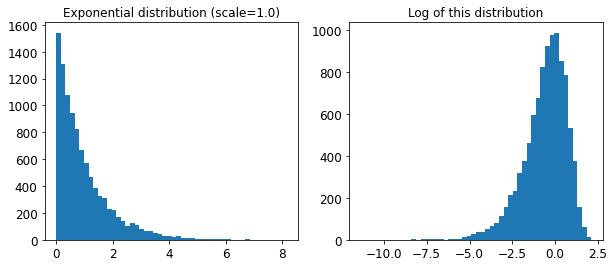

In [88]:
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()


The distribution we used for `C` looks quite different: the scale of the samples is picked from a uniform distribution within a given range, which is why the right graph, which represents the log of the samples, looks roughly constant. This distribution is useful when you don't have a clue of what the target scale is:


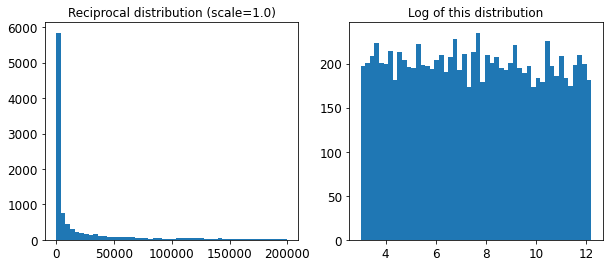

In [89]:
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()


The reciprocal distribution is useful when you have no idea what the scale of the hyperparameter should be (indeed, as you can see on the figure on the right, all scales are equally likely, within the given range), whereas the exponential distribution is best when you know (more or less) what the scale of the hyperparameter should be.


## 3. Question: Try adding a transformer in the preparation pipeline to select only the most important attributes.


In [123]:
feature_importances

array([6.94469519e-02, 6.77555156e-02, 4.20789651e-02, 1.54742093e-02,
       1.43004348e-02, 1.49898082e-02, 1.42623469e-02, 3.64609933e-01,
       2.56424528e-02, 1.13495640e-01, 9.52224535e-02, 6.17738418e-03,
       1.50850730e-01, 9.95330108e-05, 2.15382690e-03, 3.43981508e-03])

In [124]:
k = 6

In [125]:
np.argpartition(feature_importances, -k)

array([15, 13, 14, 11,  6,  4,  5,  3,  8,  2,  1,  0, 12, 10,  9,  7],
      dtype=int64)

We have the feature importances from a previous grid search. We need to find the top N ones. The original index is relevant because it's in the order of the data set columns so we need to find the indices of the highest N ones. We can dop this with argpartition. The N passed to argpartition will be the index for which we sort accordingly. Based on this element, the rest that are higher are put after it and the smaller ones are put before it. In our case the last 5 will be the highest ones and before that, the smallest ones. The partitions net NOT sorted. We just know that a partition contains the larger value. Now let's just keep the last 5 values


In [126]:
top_k_important_features = np.sort(np.argpartition(np.array(feature_importances), -k)[-k:])
top_k_important_features

array([ 0,  1,  7,  9, 10, 12], dtype=int64)

In [127]:
housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

In [128]:
housing_prepared[:, top_k_important_features]


array([[-0.94135046,  1.34743822, -0.8936472 ,  0.00622264, -0.12112176,
         1.        ],
       [ 1.17178212, -1.19243966,  1.292168  , -0.04081077, -0.81086696,
         0.        ],
       [ 0.26758118, -0.1259716 , -0.52543365, -0.07537122, -0.33827252,
         1.        ],
       ...,
       [-1.5707942 ,  1.31001828, -0.36547546, -0.03743619,  0.32286937,
         0.        ],
       [-1.56080303,  1.2492109 ,  0.16826095, -0.05915604, -0.45702273,
         0.        ],
       [-1.28105026,  2.02567448, -0.390569  ,  0.00657083, -0.12169672,
         1.        ]])

To see the names of these columns we can use the prev defined attributes prop

In [129]:
np.array(attributes)[top_k_important_features]


array(['longitude', 'latitude', 'median_income', 'pop_per_hhold',
       'bedrooms_per_room', 'INLAND'], dtype='<U18')

Now let's create a transformer that automatically does this:


In [162]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeaturesSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        indices = indices_of_top_k(self.feature_importances, self.k)
        self.feature_indices_ = indices[indices < X.shape[1]] # Added this filter because the size of the data changes at the final exercise to index out of bounds
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]


In [163]:
top_feature_selector_test = TopFeaturesSelector(feature_importances, k)
top_feature_selector_test.fit_transform(housing_prepared)

array([[-0.94135046,  1.34743822, -0.8936472 ,  0.00622264, -0.12112176,
         1.        ],
       [ 1.17178212, -1.19243966,  1.292168  , -0.04081077, -0.81086696,
         0.        ],
       [ 0.26758118, -0.1259716 , -0.52543365, -0.07537122, -0.33827252,
         1.        ],
       ...,
       [-1.5707942 ,  1.31001828, -0.36547546, -0.03743619,  0.32286937,
         0.        ],
       [-1.56080303,  1.2492109 ,  0.16826095, -0.05915604, -0.45702273,
         0.        ],
       [-1.28105026,  2.02567448, -0.390569  ,  0.00657083, -0.12169672,
         1.        ]])

Seems to work. Let's create a new pipeline to include this transformer:


In [164]:
full_pipeline_with_feature_selector = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeaturesSelector(feature_importances, k)),
])


Let's test it:


In [165]:
housing_prepared_with_top_features = full_pipeline_with_feature_selector.fit_transform(housing)
housing_prepared_with_top_features

array([[-0.94135046,  1.34743822, -0.8936472 ,  0.00622264, -0.12112176,
         1.        ],
       [ 1.17178212, -1.19243966,  1.292168  , -0.04081077, -0.81086696,
         0.        ],
       [ 0.26758118, -0.1259716 , -0.52543365, -0.07537122, -0.33827252,
         1.        ],
       ...,
       [-1.5707942 ,  1.31001828, -0.36547546, -0.03743619,  0.32286937,
         0.        ],
       [-1.56080303,  1.2492109 ,  0.16826095, -0.05915604, -0.45702273,
         0.        ],
       [-1.28105026,  2.02567448, -0.390569  ,  0.00657083, -0.12169672,
         1.        ]])

Let's look at the first 4 instances


In [166]:
housing_prepared_with_top_features[:4]


array([[-0.94135046,  1.34743822, -0.8936472 ,  0.00622264, -0.12112176,
         1.        ],
       [ 1.17178212, -1.19243966,  1.292168  , -0.04081077, -0.81086696,
         0.        ],
       [ 0.26758118, -0.1259716 , -0.52543365, -0.07537122, -0.33827252,
         1.        ],
       [ 1.22173797, -1.35147437, -0.86592882, -0.10680295,  0.96120521,
         0.        ]])

Now let's check this against the tested housing_prepared result of the pipeline without the feature selector to make sure they are the same instances


In [167]:
housing_prepared[:4, top_k_important_features]

array([[-0.94135046,  1.34743822, -0.8936472 ,  0.00622264, -0.12112176,
         1.        ],
       [ 1.17178212, -1.19243966,  1.292168  , -0.04081077, -0.81086696,
         0.        ],
       [ 0.26758118, -0.1259716 , -0.52543365, -0.07537122, -0.33827252,
         1.        ],
       [ 1.22173797, -1.35147437, -0.86592882, -0.10680295,  0.96120521,
         0.        ]])

Fuck yes. It works.


## 4 Question: Try creating a single pipeline that does the full data preparation plus the final prediction.

In [168]:
full_pipline_with_predictor_svr = Pipeline([
    ("preparation", full_pipeline),
    ("feature_selector", TopFeaturesSelector(feature_importances, k)),
    ("predictor", SVR(**rnd_search.best_params_))
])

In [169]:
full_pipline_with_predictor_svr.fit(housing, housing_labels)

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('attribs_adder',
                                                                   CombinedAttributesAdder()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                    

Let's test it on a few entries from the data


In [170]:
first_5_entries = housing.iloc[:6]
first_5_labels = housing_labels.iloc[:6]

print("Predictions:", full_pipline_with_predictor_svr.predict(first_5_entries))
print("Labels:", list(first_5_labels))


Predictions: [ 82566.15425061 295756.23350923  87383.2812635  151182.21476302
 221127.11431474 153141.12880562]
Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0, 165700.0]


## 5. Question: Automatically explore some preparation options using `GridSearchCV`.


We can use grid search to try and play around with some hyperparameters we introduced or already existed. They naming is pretty precific to specify what it is as seen below.

**Note:** In the code below, I've set the `OneHotEncoder`'s `handle_unknown` hyperparameter to `'ignore'`, to avoid warnings during training. Without this, the `OneHotEncoder` would default to `handle_unknown='error'`, meaning that it would raise an error when transforming any data containing a category it didn't see during training. If we kept the default, then the `GridSearchCV` would run into errors during training when evaluating the folds in which not all the categories are in the training set. This is likely to happen since there's only one sample in the `'ISLAND'` category, and it may end up in the test set in some of the folds. So some folds would just be dropped by the `GridSearchCV`, and it's best to avoid that.


In [171]:
full_pipline_with_predictor_svr.named_steps['preparation'].named_transformers_['cat'].handle_unknown = 'ignore'

param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selector__k': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(full_pipline_with_predictor_svr, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2)
grid_search_prep.fit(housing, housing_labels)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END feature_selector__k=1, preparation__num__imputer__strategy=mean; total time=  12.4s
[CV] END feature_selector__k=1, preparation__num__imputer__strategy=mean; total time=  11.3s
[CV] END feature_selector__k=1, preparation__num__imputer__strategy=mean; total time=  10.9s
[CV] END feature_selector__k=1, preparation__num__imputer__strategy=mean; total time=  11.1s
[CV] END feature_selector__k=1, preparation__num__imputer__strategy=mean; total time=  11.1s
[CV] END feature_selector__k=1, preparation__num__imputer__strategy=median; total time=  11.2s
[CV] END feature_selector__k=1, preparation__num__imputer__strategy=median; total time=  11.1s
[CV] END feature_selector__k=1, preparation__num__imputer__strategy=median; total time=  10.9s
[CV] END feature_selector__k=1, preparation__num__imputer__strategy=median; total time=  11.2s
[CV] END feature_selector__k=1, preparation__num__imputer__strategy=median; total time=  11.3

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preparation',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('attribs_adder',
                                                                                          CombinedAttributesAdder()),
                                                                                         ('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['longitude',
                                                                          'latitude',
       

In [172]:
grid_search_prep.best_params_

{'feature_selector__k': 16,
 'preparation__num__imputer__strategy': 'most_frequent'}

Something got screwed here. With the selection of top features based on the feature importances. There is a mismatch since we use the feature importances based on the Random Forest result and apply it when doing a SVM Regression. The result should be 15 out of 16 features. Just the last one the category "ISLAND" seems to add noise to the data. The most_frequest imputer strategy is getter however than the mean.

We did a lot!

In [173]:
cvres = grid_search_prep.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)


84856.09293593101 {'feature_selector__k': 1, 'preparation__num__imputer__strategy': 'mean'}
84856.09293593101 {'feature_selector__k': 1, 'preparation__num__imputer__strategy': 'median'}
84856.09293593101 {'feature_selector__k': 1, 'preparation__num__imputer__strategy': 'most_frequent'}
75843.91296123256 {'feature_selector__k': 2, 'preparation__num__imputer__strategy': 'mean'}
75843.91296123256 {'feature_selector__k': 2, 'preparation__num__imputer__strategy': 'median'}
75843.91296123256 {'feature_selector__k': 2, 'preparation__num__imputer__strategy': 'most_frequent'}
68110.62693597029 {'feature_selector__k': 3, 'preparation__num__imputer__strategy': 'mean'}
68110.62693597029 {'feature_selector__k': 3, 'preparation__num__imputer__strategy': 'median'}
68110.62693597029 {'feature_selector__k': 3, 'preparation__num__imputer__strategy': 'most_frequent'}
66738.69574047704 {'feature_selector__k': 4, 'preparation__num__imputer__strategy': 'mean'}
66716.58095866827 {'feature_selector__k': 4, 'p